In [1]:
# 1. Imports, loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter


# Colorblind-friendly palette from MultiModel
COLOR_PALETTE = [
    "#0072B2", "#E69F00", "#009E73", "#D55E00", "#CC79A7", "#F0E442", "#8B4513",
    "#56B4E9", "#F0A3FF", "#FFB400", "#00BFFF", "#90EE90", "#FF6347", "#8A2BE2",
    "#CD5C5C", "#4682B4", "#FFDEAD", "#32CD32", "#D3D3D3", "#999999"
]

metric = "power_draw"

# Load datasets
footprinter = pd.read_parquet("data/footprinter.parquet").groupby("timestamp")[metric].sum()
opendt = pd.read_parquet("data/opendt.parquet").groupby("timestamp")[metric].sum()
real_world = pd.read_parquet("data/real_world.parquet").groupby("timestamp")[metric].sum()

In [2]:
# 2. Postprocessing

def average_every_n(series, n):
    return series.groupby(np.arange(len(series)) // n).mean()

# Average to 5-min intervals
opendt = average_every_n(opendt, 2)
footprinter = average_every_n(footprinter, 10)
real_world = average_every_n(real_world, 10)

# Sync lengths (trim to shortest)
min_len = min(len(opendt), len(footprinter), len(real_world))
opendt = opendt.iloc[:min_len]
footprinter = footprinter.iloc[:min_len]
real_world = real_world.iloc[:min_len]

# --- Force Start Time to 2022-10-06 22:00:00 ---
start_time = pd.Timestamp("2022-10-06 22:00:00")
timestamps = pd.date_range(start=start_time, periods=min_len, freq="5T")

# Apply clean timestamps
opendt.index = timestamps
footprinter.index = timestamps
real_world.index = timestamps

/var/folders/zp/wbw59jc53p912jytp6zlm1wr0000gs/T/ipykernel_14102/3083536656.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  timestamps = pd.date_range(start=start_time, periods=min_len, freq="5T")


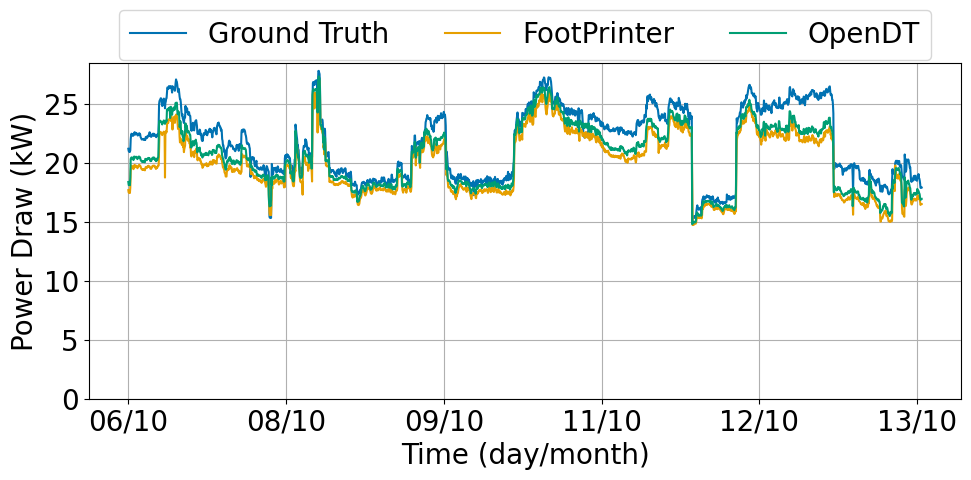

In [22]:
# 3. Plotting
x = np.arange(min_len)

plt.figure(figsize=(10, 5))  # Adjusted aspect ratio closer to your screenshot
plt.grid(True)

# Plot lines (W -> kW conversion)
# Using 'real_world' as Ground Truth to match your logic
plt.plot(x, real_world.values / 1000, label="Ground Truth", color=COLOR_PALETTE[0], lw=1.5)
plt.plot(x, footprinter.values / 1000, label="FootPrinter", color=COLOR_PALETTE[1], lw=1.5)
plt.plot(x, opendt.values / 1000, label="OpenDT", color=COLOR_PALETTE[2], lw=1.5)
# plt.plot(x, opendt.values / 1000, label="OpenDT", color=COLOR_PALETTE[2], lw=2) # Uncomment if needed

# Formatting axes
ax = plt.gca()

# X Axis: Format as "08/10", "10/10"
ax.xaxis.set_major_locator(MaxNLocator(6))
tick_positions = ax.get_xticks()
tick_positions = tick_positions[(tick_positions >= 0) & (tick_positions < min_len)].astype(int)
tick_labels = [timestamps[pos].strftime("%d/%m") for pos in tick_positions]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, fontsize=20)

# Y Axis
y_formatter = FuncFormatter(lambda val, _: f"{int(val):,}")
ax.yaxis.set_major_formatter(y_formatter)
ax.tick_params(axis='y', labelsize=20)
# start from 0
ax.set_ylim(bottom=0)
plt.ylabel("Power Draw (kW)", fontsize=20)
plt.xlabel("Time (day/month)", fontsize=20)  # Matches ticks

# Legend on top
plt.legend(fontsize=20, loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3)
plt.tight_layout()
plt.savefig("output.png", dpi=300)

In [4]:
opendt

2022-10-06 22:00:00    18370.533203
2022-10-06 22:05:00    18115.002930
2022-10-06 22:10:00    18106.490234
2022-10-06 22:15:00    18154.280273
2022-10-06 22:20:00    18098.375000
                           ...     
2022-10-13 21:20:00    17010.085938
2022-10-13 21:25:00    16858.884766
2022-10-13 21:30:00    16869.384766
2022-10-13 21:35:00    16925.380859
2022-10-13 21:40:00    16940.115234
Freq: 5min, Name: power_draw, Length: 2013, dtype: float64

In [20]:
# 4. MAPE Calculation

def calculate_mape(ground_truth, simulation):
    """
    Calculates Mean Absolute Percentage Error (MAPE).
    R = ground_truth
    S = simulation
    Formula: (1/n) * Σ |(R - S) / R| * 100
    """
    # We use .values to ensure we calculate element-wise regardless of index names
    R = ground_truth.values
    S = simulation.values

    # Calculate vector-wise
    mape = np.mean(np.abs((R - S) / R)) * 100
    return mape


# 1. Calculate MAPE for Footprinter
mape_fp = calculate_mape(real_world, footprinter)

# 2. Calculate MAPE for OpenDT
mape_odt = calculate_mape(real_world, opendt)

print(f"MAPE Footprinter: {mape_fp:.2f}%")
print(f"MAPE OpenDT:      {mape_odt:.2f}%")

MAPE Footprinter: 7.86%
MAPE OpenDT:      5.33%


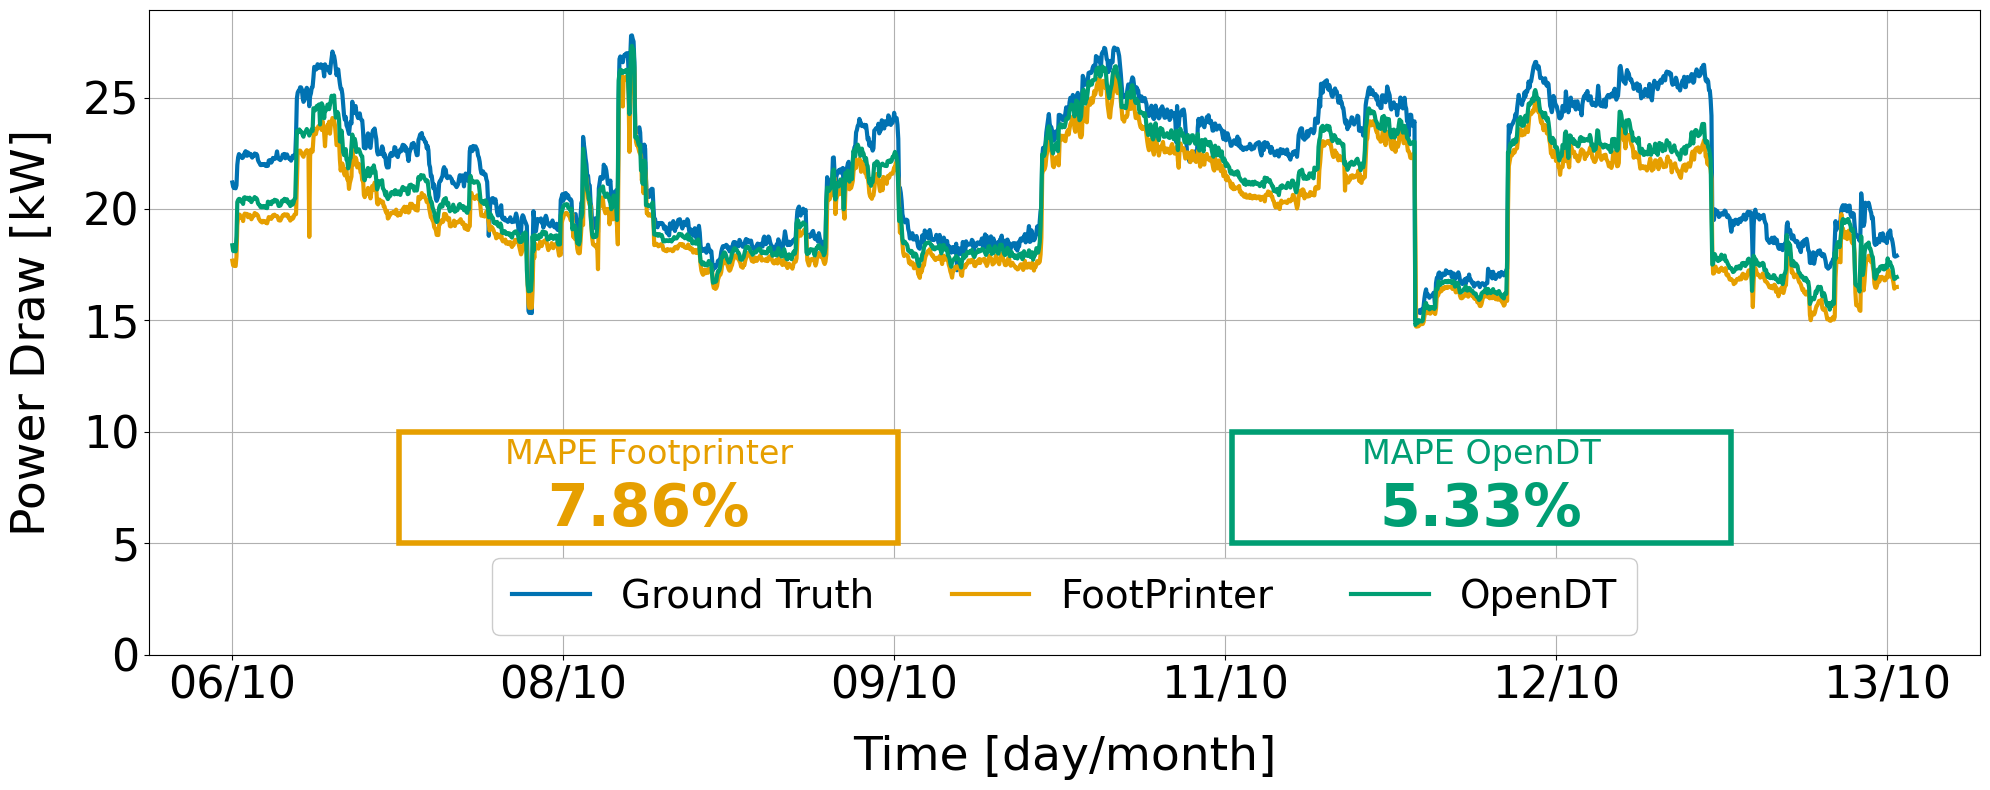

In [45]:
# 5. Plotting: Legend INSIDE (Bottom), Wider Boxes, Thinner Lines
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FuncFormatter
import numpy as np

# Ensure we have the x-axis range
x = np.arange(min_len)

# 1. Setup Figure
plt.figure(figsize=(20, 8))
plt.grid(True)

# 2. Plot Lines (Thinner: lw=3)
plt.plot(x, real_world.values / 1000, label="Ground Truth", color=COLOR_PALETTE[0], lw=3)
plt.plot(x, footprinter.values / 1000, label="FootPrinter", color=COLOR_PALETTE[1], lw=3)
plt.plot(x, opendt.values / 1000, label="OpenDT", color=COLOR_PALETTE[2], lw=3)

# 3. Draw Custom Info Boxes
ax = plt.gca()

# Box Parameters (Wider Boxes: 0.30 width)
box_width = min_len * 0.30  # Increased width slightly more
box_height = 5
box_y_center = 7.5
box_y_bottom = box_y_center - (box_height / 2)  # Bottom edge is at y=2


# --- Function to draw a stats box ---
def draw_stat_box(x_center, color, title, value):
    rect = patches.Rectangle(
        (x_center - box_width / 2, box_y_bottom),
        box_width, box_height,
        linewidth=4, edgecolor=color, facecolor='white', zorder=10
    )
    ax.add_patch(rect)

    ax.text(x_center, box_y_center + 1.5,
            title,
            fontsize=24, color=color, ha='center', va='center', zorder=11)

    ax.text(x_center, box_y_center - 1.0,
            value,
            fontsize=42, fontweight='bold', color=color, ha='center', va='center', zorder=11)


# Draw Box 1: Footprinter
draw_stat_box(min_len * 0.25, COLOR_PALETTE[1], "MAPE Footprinter", f"{mape_fp:.2f}%")

# Draw Box 2: OpenDT
draw_stat_box(min_len * 0.75, COLOR_PALETTE[2], "MAPE OpenDT", f"{mape_odt:.2f}%")

# 4. Formatting Axes

# X-Axis
ax.xaxis.set_major_locator(MaxNLocator(6))
tick_positions = ax.get_xticks()
tick_positions = tick_positions[(tick_positions >= 0) & (tick_positions < min_len)].astype(int)
tick_labels = [timestamps[pos].strftime("%d/%m") for pos in tick_positions]
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, fontsize=32)

# Y-Axis
y_formatter = FuncFormatter(lambda val, _: f"{int(val):,}")
ax.yaxis.set_major_formatter(y_formatter)
ax.tick_params(axis='y', labelsize=32)

# Labels
plt.ylabel("Power Draw [kW]", fontsize=34, labelpad=20)
plt.xlabel("Time [day/month]", fontsize=34, labelpad=20)
plt.ylim(bottom=0)

# 5. Legend (Overlapping Plot, Bottom Center)
# loc="lower center" puts it inside the axes at the bottom.
# framealpha=1 ensures the white background of the legend blocks grid lines.
plt.legend(fontsize=28, loc="lower center", ncol=3, framealpha=1, borderpad=0.5)

plt.tight_layout()

# Save
plt.savefig("power_draw_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()